In [2]:
'''

All v6.x is based on the 5.0 version

Key changes:
- Added rolling sales statistics (7d, 30d, 90d)
- Special features for Warengruppe 6 (active periods, historical monthly sales)
- Increased model complexity (more LSTM units, additional dense layer)
- Longer training with earlier stopping
- Separate feature handling per Warengruppe

'''
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
df_kiwo = pd.read_csv('../../Data/kiwo.csv')
df_umsatz = pd.read_csv('../../Data/train.csv')
df_wetter = pd.read_csv('../../Data/wetter.csv')
df_test = pd.read_csv('../../Data/test.csv')

def prepare_temporal_features(data, historical_data=None):
    data = data.copy()
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['Month'] = data['Datum'].dt.month  # Move this here
    data = data.sort_values('Datum')
    
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)

    # Split data by Warengruppe
    groups = []
    for wg in range(1, 7):
        wg_data = data[data['Warengruppe'] == wg].copy()
        
        if historical_data is not None:
            hist_wg = historical_data[historical_data['Warengruppe'] == wg].copy()
            hist_wg['Datum'] = pd.to_datetime(hist_wg['Datum'])
            hist_wg['Month'] = hist_wg['Datum'].dt.month
            
            # Create rolling features
            wg_data['sales_7d'] = hist_wg['Umsatz'].rolling(7, min_periods=1).mean()
            wg_data['sales_30d'] = hist_wg['Umsatz'].rolling(30, min_periods=1).mean()
            wg_data['sales_90d'] = hist_wg['Umsatz'].rolling(90, min_periods=1).mean()
            
            # Special handling for Warengruppe 6
            if wg == 6:
                # Detect active selling periods
                threshold = hist_wg['Umsatz'].quantile(0.75)
                wg_data['is_active'] = (hist_wg['Umsatz'] > threshold).astype(float)
                
                # Create seasonal windows
                wg_data['month_sales_last_year'] = hist_wg.groupby('Month')['Umsatz'].transform('mean')
        else:
            # For test data, use zeros as placeholders
            wg_data['sales_7d'] = 0
            wg_data['sales_30d'] = 0
            wg_data['sales_90d'] = 0
            if wg == 6:
                wg_data['is_active'] = 0
                wg_data['month_sales_last_year'] = 0
        
        groups.append(wg_data)
    
    data = pd.concat(groups)
    
    # Create final feature set
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 
                     'IsWeekend', 'KielerWoche', 'sales_7d', 'sales_30d', 'sales_90d']
    
    if 'is_active' in data.columns:
        numerical_cols.extend(['is_active', 'month_sales_last_year'])
    
    # One-hot encodings
    categorical_features = pd.concat([
        pd.get_dummies(data['Warengruppe'], prefix='Warengruppe'),
        pd.get_dummies(data['DayOfWeek'], prefix='Day'),
        pd.get_dummies(data['Month'], prefix='Month')
    ], axis=1)
    
    # Combine features
    feature_df = pd.concat([data[numerical_cols], categorical_features], axis=1)
    
    return feature_df, data['Umsatz'] if 'Umsatz' in data.columns else None    data = data.copy()
    

# Prepare datasets
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_train_sorted = df_train.sort_values('Datum')

df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

X_train, y_train = prepare_temporal_features(df_train_sorted, historical_data=df_train_sorted)
X_test, _ = prepare_temporal_features(df_test, historical_data=df_train_sorted)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split data
split_idx = int(len(X_train_scaled) * 0.8)
X_train_seq = X_train_scaled[:split_idx].reshape(-1, 1, X_train_scaled.shape[1])
X_val_seq = X_train_scaled[split_idx:].reshape(-1, 1, X_train_scaled.shape[1])
y_train_seq = y_train[:split_idx]
y_val_seq = y_train[split_idx:]
X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

# Build model
model = tf.keras.Sequential([
    LSTM(128, activation='relu', input_shape=(1, X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1
)

# Make predictions
val_predictions = model.predict(X_val_seq).flatten()
test_predictions = model.predict(X_test_seq).flatten()

# Save results
df_test['Predicted_Umsatz'] = test_predictions
df_test.to_csv('predicted_test.csv', index=False)

# Calculate MAPE by Warengruppe
results_df = pd.DataFrame({
    'Warengruppe': df_train_sorted.iloc[split_idx:]['Warengruppe'],
    'Actual': y_val_seq,
    'Predicted': val_predictions
})

mape_by_group = results_df.groupby('Warengruppe').apply(
    lambda x: MeanAbsolutePercentageError()(x['Actual'], x['Predicted']).numpy()
).sort_values()

print("\nMAPE by Warengruppe:")
for warengruppe, mape in mape_by_group.items():
    print(f"Warengruppe {warengruppe}: {mape:.2f}%")

SyntaxError: invalid syntax (827454783.py, line 91)

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
df_kiwo = pd.read_csv('../../Data/kiwo.csv')
df_umsatz = pd.read_csv('../../Data/train.csv')
df_wetter = pd.read_csv('../../Data/wetter.csv')
df_test = pd.read_csv('../../Data/test.csv')

def prepare_temporal_features(data, historical_data=None):
    data = data.copy()
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['Month'] = data['Datum'].dt.month
    data = data.sort_values('Datum')
    
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)

    # Split data by Warengruppe
    groups = []
    for wg in range(1, 7):
        wg_data = data[data['Warengruppe'] == wg].copy()
        
        if historical_data is not None:
            hist_wg = historical_data[historical_data['Warengruppe'] == wg].copy()
            hist_wg['Datum'] = pd.to_datetime(hist_wg['Datum'])
            hist_wg['Month'] = hist_wg['Datum'].dt.month
            
            # Create rolling features
            wg_data['sales_7d'] = hist_wg['Umsatz'].rolling(7, min_periods=1).mean()
            wg_data['sales_30d'] = hist_wg['Umsatz'].rolling(30, min_periods=1).mean()
            wg_data['sales_90d'] = hist_wg['Umsatz'].rolling(90, min_periods=1).mean()
            
            # Special handling for Warengruppe 6
            if wg == 6:
                # Detect active selling periods
                threshold = hist_wg['Umsatz'].quantile(0.75)
                wg_data['is_active'] = (hist_wg['Umsatz'] > threshold).astype(float)
                
                # Create seasonal windows
                wg_data['month_sales_last_year'] = hist_wg.groupby('Month')['Umsatz'].transform('mean')
        else:
            # For test data, use zeros as placeholders
            wg_data['sales_7d'] = 0
            wg_data['sales_30d'] = 0
            wg_data['sales_90d'] = 0
            if wg == 6:
                wg_data['is_active'] = 0
                wg_data['month_sales_last_year'] = 0
        
        groups.append(wg_data)
    
    data = pd.concat(groups)
    
    # Create final feature set
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 
                     'IsWeekend', 'KielerWoche', 'sales_7d', 'sales_30d', 'sales_90d']
    
    if 'is_active' in data.columns:
        numerical_cols.extend(['is_active', 'month_sales_last_year'])
    
    # One-hot encodings
    categorical_features = pd.concat([
        pd.get_dummies(data['Warengruppe'], prefix='Warengruppe'),
        pd.get_dummies(data['DayOfWeek'], prefix='Day'),
        pd.get_dummies(data['Month'], prefix='Month')
    ], axis=1)
    
    # Combine features
    feature_df = pd.concat([data[numerical_cols], categorical_features], axis=1)
    
    return feature_df, data['Umsatz'] if 'Umsatz' in data.columns else None

# Prepare datasets
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_train_sorted = df_train.sort_values('Datum')

df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

X_train, y_train = prepare_temporal_features(df_train_sorted, historical_data=df_train_sorted)
X_test, _ = prepare_temporal_features(df_test, historical_data=df_train_sorted)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split data
split_idx = int(len(X_train_scaled) * 0.8)
X_train_seq = X_train_scaled[:split_idx].reshape(-1, 1, X_train_scaled.shape[1])
X_val_seq = X_train_scaled[split_idx:].reshape(-1, 1, X_train_scaled.shape[1])
y_train_seq = y_train[:split_idx]
y_val_seq = y_train[split_idx:]
X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

# Build model
model = tf.keras.Sequential([
    LSTM(128, activation='relu', input_shape=(1, X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1
)

# Make predictions
val_predictions = model.predict(X_val_seq).flatten()
test_predictions = model.predict(X_test_seq).flatten()

# Save results
df_test['Predicted_Umsatz'] = test_predictions
df_test.to_csv('predicted_test.csv', index=False)

# Calculate MAPE by Warengruppe
results_df = pd.DataFrame({
    'Warengruppe': df_train_sorted.iloc[split_idx:]['Warengruppe'],
    'Actual': y_val_seq,
    'Predicted': val_predictions
})

mape_by_group = results_df.groupby('Warengruppe').apply(
    lambda x: MeanAbsolutePercentageError()(x['Actual'], x['Predicted']).numpy()
).sort_values()

print("\nMAPE by Warengruppe:")
for warengruppe, mape in mape_by_group.items():
    print(f"Warengruppe {warengruppe}: {mape:.2f}%")

Epoch 1/5


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 61719.0234 - mean_absolute_percentage_error: 99.9551 - val_loss: 71690.1328 - val_mean_absolute_percentage_error: 99.8534
Epoch 2/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60969.3086 - mean_absolute_percentage_error: 99.7712 - val_loss: 71578.6719 - val_mean_absolute_percentage_error: 99.7066
Epoch 3/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60814.8789 - mean_absolute_percentage_error: 99.5914 - val_loss: 71467.1875 - val_mean_absolute_percentage_error: 99.5596
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60897.2148 - mean_absolute_percentage_error: 99.4073 - val_loss: 71355.8594 - val_mean_absolute_percentage_error: 99.4126
Epoch 5/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61247.6914 - mean_absolute_percentage_error: 99.2271 - val_loss: 71244.7188 - val_mean_absolute_percentage_error: 99.2657
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


ValueError: array length 1867 does not match index length 3316

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

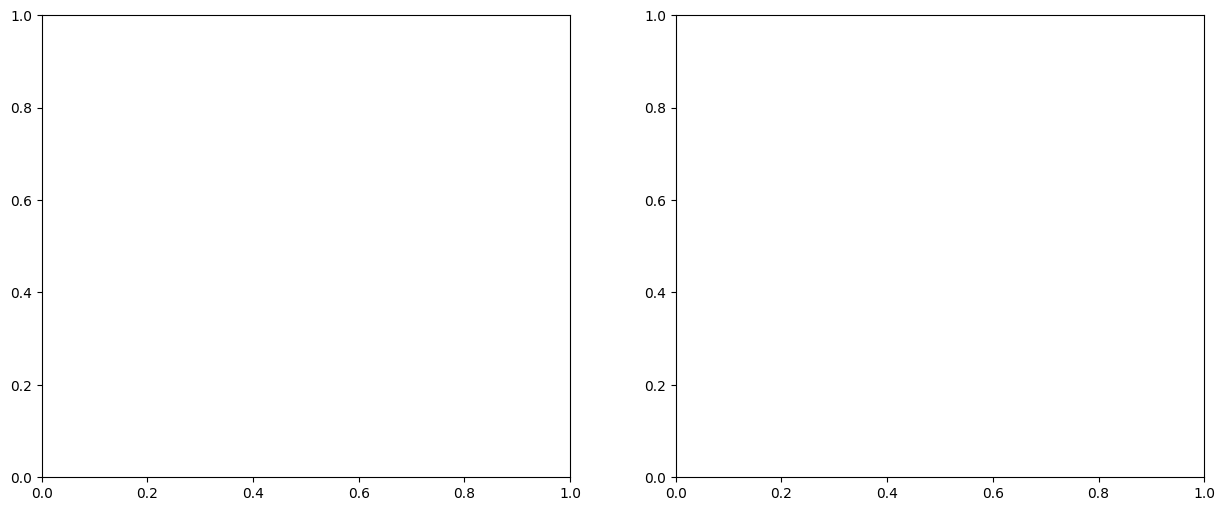

In [4]:
# this code belongs up top, takes the data from X_train to make bar charts

import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First plot: Weekdays
day_counts = []
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(1, 8):  # 7 days
    day_counts.append(X_train[f'Day_{i}'].sum())  # sum() counts True values

# Plot weekdays
bars1 = ax1.bar(day_names, day_counts)
ax1.set_title('Number of Occurrences by Weekday')
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Second plot: Months
month_counts = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(1, 13):  # 12 months
    month_counts.append(X_train[f'Month_{i}'].sum())  # sum() counts True values

# Plot months
bars2 = ax2.bar(month_names, month_counts)
ax2.set_title('Number of Occurrences by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()